## Library

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Anchors (customize these)

In [2]:
def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sample(brain)
    eff_ = sample(efficiency)
    tvh_ = sample(transformative_vs_human)
    h_ = sample(horizon_length)
    e_ = sample(scaling_exponent)
    fpp_ = sample(flops_per_param_per_sec)
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
        if debug:
            print(f"{brain_} + {eff_} + {tvh_} + {h_} + {ref_params_samples} - {e_} * {ref_params} + {e_} * ({brain_} + {eff_} - {fpp_})")
    else:
        params_ = sample(params)
        if debug:
            print(f"{brain_} + {eff_} + {tvh_} + {h_} + {ref_params_samples} - {e_} * {ref_params} + {e_} * {params_}")
        
    return bayes_update(brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_)


def cotra_bayes_update_against_low_flop(f):
    f = f + sample(norm(1,3)) if f < 27 and random.random() > 0.3 else f
    f = f + sample(norm(1,3)) if f < 26 and random.random() > 0.2 else f
    f = f + sample(norm(1,3)) if f < 25 and random.random() > 0.1 else f
    f = f + sample(norm(1,3)) if f < 24 else f
    f = 24 if f < 24 else f
    return f


def sample_cotra_anchor(horizon_length, bayes_update=cotra_bayes_update_against_low_flop):
    return sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                     efficiency=const(1),
                                     transformative_vs_human=norm(-2,2),
                                     horizon_length=horizon_length,
                                     scaling_exponent=norm(0.5,1.1),
                                     flops_per_param_per_sec=norm(1,2),
                                     bayes_update=bayes_update)

cotra_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                                          efficiency=distributed_lognorm([[2,5],[5,9]],[0.5,0.5]),
                                                          transformative_vs_human=norm(-2,2),
                                                          horizon_length=const(9),
                                                          scaling_exponent=const(0),
                                                          flops_per_param_per_sec=const(0),
                                                          ref_params_samples=0,
                                                          bayes_update=cotra_bayes_update_against_low_flop)

cotra_gpt_anchor = lambda: sample_cotra_anchor(horizon_length=const(0))
cotra_short_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=norm(0,3))
cotra_medium_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=norm(3,6))
cotra_long_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=norm(6,9))

cotra_genome_anchor = lambda: sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                                        params=norm(8.3,9.44), # Centered on 8.87... there are ~10^8.7 'params' in genome
                                                        efficiency=norm(0,2),
                                                        transformative_vs_human=norm(-2,2),
                                                        horizon_length=norm(7,9),
                                                        scaling_exponent=norm(0.5,1.1),
                                                        flops_per_param_per_sec=norm(1,2),
                                                        bayes_update=cotra_bayes_update_against_low_flop)

average_ancestor_brain_flops = lognorm(3,6)
log_n_individuals = norm(20,22)
evo_time_log_sec = const(16)
cotra_evolution_anchor = lambda: sample_tai_log_flop_needs(brain=average_ancestor_brain_flops,
                                                           efficiency=norm(-6,5), # TODO: This seems not quite right
                                                           transformative_vs_human=norm(-2,2),
                                                           horizon_length=lambda: (sample(log_n_individuals) +
                                                                                   sample(evo_time_log_sec)),
                                                           scaling_exponent=const(0),
                                                           flops_per_param_per_sec=const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=None)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency
simple_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                                           efficiency=const(0),
                                                           transformative_vs_human=const(0),
                                                           horizon_length=const(9),
                                                           scaling_exponent=const(0),
                                                           flops_per_param_per_sec=const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=cotra_bayes_update_against_low_flop)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency OR
# attempt to Bayesian update against low-end FLOP
simple_lifetime_anchor_noup = lambda: sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                                                efficiency=const(0),
                                                                transformative_vs_human=const(0),
                                                                horizon_length=const(9),
                                                                scaling_exponent=const(0),
                                                                flops_per_param_per_sec=const(0),
                                                                ref_params_samples=0,
                                                                bayes_update=None)

print('Loaded')

Loaded


## Variables (customize these)

In [3]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Cotra2020'                         # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
VARIABLE_SETS = {}


# Cotra (2020)
def cotra_2020_anchor_weights():
    r_ = random.random()
    if r_ < 0.052:
        return sample(cotra_lifetime_anchor)
    elif r_ < 0.262:
        return sample(cotra_short_horizon_nn_anchor)
    elif r_ < 0.372:
        return sample(cotra_genome_anchor)
    elif r_ < 0.684:
        return sample(cotra_medium_horizon_nn_anchor)
    elif r_ < 0.839:
        return sample(cotra_long_horizon_nn_anchor)
    elif r_ < 0.93:
        return sample(cotra_evolution_anchor)
    else:
        return sample(lognorm(60,70)) # No path anchor
    
VARIABLE_SETS['Cotra2020'] = {
    'initial_gdp': 21 * trillion, # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)
    'tai_flop_size': cotra_2020_anchor_weights,
    # 90% CI, it takes 10^X FLOPs to run a transformative AI at inference.
    # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day,
    # or a total of about 10^20 operations
    'algo_doubling_rate_max': const(3.5),        # 90% CI, algorithms get twice as efficient every X years (maximum)
    'algo_doubling_rate_min': const(2),          # 90% CI, algorithms get twice as efficient every X years (minimum)
    'min_reduction': const(2),                   # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'max_reduction': const(5),                   # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'initial_flops_per_dollar': const(17),       # 90% CI, as of today, we can buy 10^X FLOPs per $
    'flops_halving_rate': const(2.5),            # 90% CI, the cost of FLOPs per $ halves every X years
    'max_flops_per_dollar': const(24),           # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    'initial_pay': const(8.7),                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    'gdp_growth': const(1.03),                   # 90% CI, GDP will increase by a factor of X each year
    'max_gdp_frac': const(0.01),                 # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    'spend_doubling_time': const(2.5)            # 90% CI, our willingness to spend on TAI doubles every X years
}


# Cotra's 2022 update
def cotra_2022_anchor_weights():
    r_ = random.random()
    if r_ < 0.1:
        return sample(cotra_gpt_anchor)
    elif r_< 0.43:
        return sample(cotra_short_horizon_nn_anchor)
    elif r_ < 0.52:
        return sample(cotra_genome_anchor)
    elif r_ < 0.86:
        return sample(cotra_medium_horizon_nn_anchor)
    elif r_ < 0.9:
        return sample(cotra_long_horizon_nn_anchor)
    elif r_ < 0.95:
        return sample(cotra_evolution_anchor)
    else:
        return sample(lognorm(60,70)) # No path anchor

VARIABLE_SETS['Cotra2022'] = deepcopy(VARIABLE_SETS['Cotra2020'])
VARIABLE_SETS['Cotra2022']['tai_flop_size'] = cotra_2022_anchor_weights
VARIABLE_SETS['Cotra2022']['initial_flops_per_dollar'] = const(18)


# My variables
def wildeford_horizon_length():
    r_ = random.random()
    if r_ < 0.4:
        h = 0
    elif r_ < 0.6:
        h = sample(norm(0,3))
    elif r_ < 0.85:
        h = sample(lognorm(3,7))
    else:
        h = sample(norm(7,11))
        
    if h < 0:
        h = 0
    
    return h

def wildeford_bayes_update_against_low_flop(f):
    f = f + sample(norm(1,3)) if f < 27 and random.random() > 0.9 else f
    f = f + sample(norm(1,3)) if f < 26 and random.random() > 0.8 else f
    f = f + sample(norm(1,3)) if f < 25 and random.random() > 0.4 else f
    f = f + sample(norm(1,3)) if f < 24 and random.random() > 0.1 else f
    return f

wildeford_meta_anchor = lambda: sample_tai_log_flop_needs(brain=lognorm(11,19.5),
                                                          efficiency=lognorm(1,5),#norm(-1,2),
                                                          transformative_vs_human=norm(-2,2),
                                                          horizon_length=wildeford_horizon_length,
                                                          scaling_exponent=norm(0.5,1.5),
                                                          flops_per_param_per_sec=norm(1,2),
                                                          bayes_update=wildeford_bayes_update_against_low_flop)

VARIABLE_SETS['Wildeford'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Wildeford']['tai_flop_size'] = wildeford_meta_anchor
#VARIABLE_SETS['Wildeford']['min_reduction'] = const(10) #norm(0, 3, lclip=0)
#VARIABLE_SETS['Wildeford']['max_reduction'] = const(10) #norm(4, 8)
#VARIABLE_SETS['Wildeford']['algo_doubling_rate_max'] = const(1) #lognorm(1.5, 4.5)
#VARIABLE_SETS['Wildeford']['algo_doubling_rate_min'] = const(1) #lognorm(1, 3, lclip=0.5)
#VARIABLE_SETS['Wildeford']['initial_flops_per_dollar'] = lognorm(17.5, 18.5)
VARIABLE_SETS['Wildeford']['flops_halving_rate'] = lognorm(2, 5)
#VARIABLE_SETS['Wildeford']['max_flops_per_dollar'] = norm(22, 27)
VARIABLE_SETS['Wildeford']['initial_pay'] = distributed_lognorm([[7.1,7.1],[7.1,9]],[0.8,0.2], lclip=7.3) #NEW
#VARIABLE_SETS['Wildeford']['gdp_growth'] = const(1.02) #norm(1.015, 1.035)

def wildeford_max_gdp_frac():
    small_project = lognorm(0.0002,0.001)
    modern_megaproject = lognorm(0.001,0.002)
    old_form_megaproject = lognorm(0.002,0.006)
    gigaproject = lognorm(0.004,0.02)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
    elif r_ < 0.8:
        gdp_frac = modern_megaproject
    elif r_ < 0.95:
        gdp_frac = old_form_megaproject
    else:
        gdp_frac = gigaproject
        
    percent_spent_on_compute = lognorm(0.2,0.95, lclip=0.1, rclip=0.9)
    return sample(gdp_frac) * sample(percent_spent_on_compute)

VARIABLE_SETS['Wildeford']['max_gdp_frac'] = wildeford_max_gdp_frac #NEW
#VARIABLE_SETS['Wildeford']['p_willingness_ramp'] = 0.1
#VARIABLE_SETS['Wildeford']['willingness_ramp'] = norm(0.3, 0.9)
#VARIABLE_SETS['Wildeford']['willingness_spend_horizon'] = norm(1,3) #NEW based on https://epochai.org/blog/the-longest-training-run
VARIABLE_SETS['Wildeford']['spend_doubling_time'] = distributed_lognorm([[2,6],[1,2]], [0.8,0.2], lclip=1) #NEW
VARIABLE_SETS['Wildeford']['initial_chance_of_nonscaling_issue'] = 0.9
VARIABLE_SETS['Wildeford']['final_chance_of_nonscaling_issue'] = 0.2 #NEW
VARIABLE_SETS['Wildeford']['nonscaling_issue_bottom_year'] = 2040
VARIABLE_SETS['Wildeford']['nonscaling_delay'] = distributed_lognorm([[2,10],[2,35]], [0.7,0.3], lclip=1) #NEW


# Kokotajlo (very short timelines, some guesses)
VARIABLE_SETS['Kokotajlo'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Kokotajlo']['tai_flop_size'] = lognorm(24, 39)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_max'] = const(1)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_min'] = const(1)
VARIABLE_SETS['Kokotajlo']['p_willingness_ramp'] = 1
VARIABLE_SETS['Kokotajlo']['willingness_ramp'] = const(0.1)
VARIABLE_SETS['Kokotajlo']['spend_doubling_time'] = const(1)


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 700:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)
"""
def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    max_reduction = max(tai_flop_size - 24, 0)
    min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)
"""

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 700:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 700:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
variables = VARIABLE_SETS[USE_NUMBERS]
print('Loaded')


Loaded


{1: 26.12239669675172,
 5: 27.52128665718806,
 10: 28.549219470520633,
 20: 30.5089096254566,
 30: 32.06816060177581,
 40: 33.515260697776654,
 50: 34.93959263618538,
 60: 36.637610454098315,
 70: 38.501043473131176,
 80: 41.02512431450002,
 90: 45.515442820450204,
 95: 62.683174670113,
 99: 68.01265205475755}


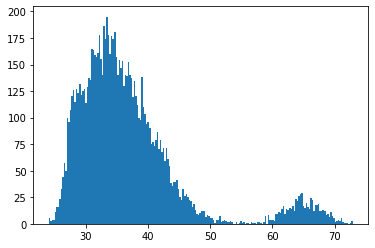

In [4]:
initial_flop_size_s = sample(variables['tai_flop_size'], n=10000)
initial_flops_p = get_percentiles(initial_flop_size_s)
plt.hist(initial_flop_size_s, bins = 200)
pprint(initial_flops_p)

In [5]:
min_reduction_p = get_percentiles(sample(variables['min_reduction'], n=1000))
min_reduction_p

{1: 2.0,
 5: 2.0,
 10: 2.0,
 20: 2.0,
 30: 2.0,
 40: 2.0,
 50: 2.0,
 60: 2.0,
 70: 2.0,
 80: 2.0,
 90: 2.0,
 95: 2.0,
 99: 2.0}

In [6]:
max_reduction_p = get_percentiles(sample(variables['max_reduction'], n=1000), reverse=True)
max_reduction_p

{99: 5.0,
 95: 5.0,
 90: 5.0,
 80: 5.0,
 70: 5.0,
 60: 5.0,
 50: 5.0,
 40: 5.0,
 30: 5.0,
 20: 5.0,
 10: 5.0,
 5: 5.0,
 1: 5.0}

In [7]:
algo_doubling_rate_min_p = get_percentiles(sample(variables['algo_doubling_rate_min'], n=1000), reverse=True)
algo_doubling_rate_min_p

{99: 2.0,
 95: 2.0,
 90: 2.0,
 80: 2.0,
 70: 2.0,
 60: 2.0,
 50: 2.0,
 40: 2.0,
 30: 2.0,
 20: 2.0,
 10: 2.0,
 5: 2.0,
 1: 2.0}

In [8]:
algo_doubling_rate_max_p = get_percentiles(sample(variables['algo_doubling_rate_max'], n=1000), reverse=True)
algo_doubling_rate_max_p

{99: 3.5,
 95: 3.5,
 90: 3.5,
 80: 3.5,
 70: 3.5,
 60: 3.5,
 50: 3.5,
 40: 3.5,
 30: 3.5,
 20: 3.5,
 10: 3.5,
 5: 3.5,
 1: 3.5}

In [9]:
initial_flops_per_dollar_p = get_percentiles(sample(variables['initial_flops_per_dollar'], n=1000))
initial_flops_per_dollar_p

{1: 17.0,
 5: 17.0,
 10: 17.0,
 20: 17.0,
 30: 17.0,
 40: 17.0,
 50: 17.0,
 60: 17.0,
 70: 17.0,
 80: 17.0,
 90: 17.0,
 95: 17.0,
 99: 17.0}

In [10]:
flops_halving_rate_p = get_percentiles(sample(variables['flops_halving_rate'], n=1000), reverse=True)
flops_halving_rate_p

{99: 2.5,
 95: 2.5,
 90: 2.5,
 80: 2.5,
 70: 2.5,
 60: 2.5,
 50: 2.5,
 40: 2.5,
 30: 2.5,
 20: 2.5,
 10: 2.5,
 5: 2.5,
 1: 2.5}

In [11]:
max_flops_per_dollar_p = get_percentiles(sample(variables['max_flops_per_dollar'], n=1000))
max_flops_per_dollar_p

{1: 24.0,
 5: 24.0,
 10: 24.0,
 20: 24.0,
 30: 24.0,
 40: 24.0,
 50: 24.0,
 60: 24.0,
 70: 24.0,
 80: 24.0,
 90: 24.0,
 95: 24.0,
 99: 24.0}

In [12]:
initial_pay_p = get_percentiles(sample(variables['initial_pay'], n=1000))
initial_pay_p

{1: 8.7,
 5: 8.7,
 10: 8.7,
 20: 8.7,
 30: 8.7,
 40: 8.7,
 50: 8.7,
 60: 8.7,
 70: 8.7,
 80: 8.7,
 90: 8.7,
 95: 8.7,
 99: 8.7}

In [13]:
gdp_growth_p = get_percentiles(sample(variables['gdp_growth'], n=1000))
gdp_growth_p

{1: 1.03,
 5: 1.03,
 10: 1.03,
 20: 1.03,
 30: 1.03,
 40: 1.03,
 50: 1.03,
 60: 1.03,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.03}

In [14]:
max_gdp_frac_p = get_percentiles(sample(variables['max_gdp_frac'], n=1000))
max_gdp_frac_p

{1: 0.01,
 5: 0.01,
 10: 0.01,
 20: 0.010000000000000002,
 30: 0.01,
 40: 0.01,
 50: 0.01,
 60: 0.01,
 70: 0.01,
 80: 0.01,
 90: 0.01,
 95: 0.01,
 99: 0.01}

In [15]:
willingness_ramp = variables.get('willingness_ramp', 0)
if willingness_ramp != 0:
    willingness_ramp_p = get_percentiles(sample(willingness_ramp), n=1000)
    pprint(willingness_ramp_p)
else:
    print(0)

0


In [16]:
spend_doubling_time_p = get_percentiles(sample(variables['spend_doubling_time'], n=1000), reverse=True)
spend_doubling_time_p

{99: 2.5,
 95: 2.5,
 90: 2.5,
 80: 2.5,
 70: 2.5,
 60: 2.5,
 50: 2.5,
 40: 2.5,
 30: 2.5,
 20: 2.5,
 10: 2.5,
 5: 2.5,
 1: 2.5}

In [17]:
nonscaling_delay = variables.get('nonscaling_delay', 0)
if nonscaling_delay != 0:
    nonscaling_delay_p = get_percentiles(np.ceil(sample(nonscaling_delay, n=1000)), reverse=True)
    pprint(nonscaling_delay_p)
else:
    print(0)

0


In [18]:
willingness_spend_horizon = variables.get('willingness_spend_horizon', 1)
if willingness_spend_horizon != 1:
    willingness_spend_horizon_p = get_percentiles(sample(willingness_spend_horizon, n=1000))
    pprint(willingness_spend_horizon_p)
else:
    print(1)

1


## GDP Over Time

Text(0, 0.5, 'log GDP')

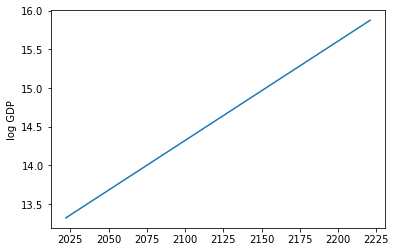

In [19]:
gdp_ = np.array([gdp(initial_gdp=variables['initial_gdp'],
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [20]:
for y in years:
    print('Year: {} - GDP log 2022$USD {} (~{})'.format(y,
                                                        np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                                        numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2023 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2024 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2032 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2033 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2034 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2035 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2036 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2037 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2038 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2039 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2040 - GDP log 2022$USD 13.6 (~10 trillion)
Year: 2041 - GDP log 2022$USD 13.6 (~10 trillion)


## Willingness to Pay Over Time

-
-
## 20 ##
Year: 2022 - willingness log 2022$USD per year 8.7 (~100 million)
Year: 2023 - willingness log 2022$USD per year 8.8 (~100 million)
Year: 2024 - willingness log 2022$USD per year 8.9 (~100 million)
Year: 2025 - willingness log 2022$USD per year 9.1 (~one billion)
Year: 2026 - willingness log 2022$USD per year 9.2 (~one billion)
Year: 2027 - willingness log 2022$USD per year 9.3 (~one billion)
Year: 2028 - willingness log 2022$USD per year 9.4 (~one billion)
Year: 2029 - willingness log 2022$USD per year 9.5 (~one billion)
Year: 2030 - willingness log 2022$USD per year 9.7 (~one billion)
Year: 2031 - willingness log 2022$USD per year 9.8 (~one billion)
Year: 2032 - willingness log 2022$USD per year 9.9 (~one billion)
Year: 2033 - willingness log 2022$USD per year 10.0 (~10 billion)
Year: 2034 - willingness log 2022$USD per year 10.1 (~10 billion)
Year: 2035 - willingness log 2022$USD per year 10.2 (~10 billion)
Year: 2036 - willingness log 2022$USD per year 10.4 (~10 billio

-
-
## 50 ##
Year: 2022 - willingness log 2022$USD per year 8.7 (~100 million)
Year: 2023 - willingness log 2022$USD per year 8.8 (~100 million)
Year: 2024 - willingness log 2022$USD per year 8.9 (~100 million)
Year: 2025 - willingness log 2022$USD per year 9.1 (~one billion)
Year: 2026 - willingness log 2022$USD per year 9.2 (~one billion)
Year: 2027 - willingness log 2022$USD per year 9.3 (~one billion)
Year: 2028 - willingness log 2022$USD per year 9.4 (~one billion)
Year: 2029 - willingness log 2022$USD per year 9.5 (~one billion)
Year: 2030 - willingness log 2022$USD per year 9.7 (~one billion)
Year: 2031 - willingness log 2022$USD per year 9.8 (~one billion)
Year: 2032 - willingness log 2022$USD per year 9.9 (~one billion)
Year: 2033 - willingness log 2022$USD per year 10.0 (~10 billion)
Year: 2034 - willingness log 2022$USD per year 10.1 (~10 billion)
Year: 2035 - willingness log 2022$USD per year 10.2 (~10 billion)
Year: 2036 - willingness log 2022$USD per year 10.4 (~10 billio

Year: 2022 - willingness log 2022$USD per year 8.7 (~100 million)
Year: 2023 - willingness log 2022$USD per year 8.8 (~100 million)
Year: 2024 - willingness log 2022$USD per year 8.9 (~100 million)
Year: 2025 - willingness log 2022$USD per year 9.1 (~one billion)
Year: 2026 - willingness log 2022$USD per year 9.2 (~one billion)
Year: 2027 - willingness log 2022$USD per year 9.3 (~one billion)
Year: 2028 - willingness log 2022$USD per year 9.4 (~one billion)
Year: 2029 - willingness log 2022$USD per year 9.5 (~one billion)
Year: 2030 - willingness log 2022$USD per year 9.7 (~one billion)
Year: 2031 - willingness log 2022$USD per year 9.8 (~one billion)
Year: 2032 - willingness log 2022$USD per year 9.9 (~one billion)
Year: 2033 - willingness log 2022$USD per year 10.0 (~10 billion)
Year: 2034 - willingness log 2022$USD per year 10.1 (~10 billion)
Year: 2035 - willingness log 2022$USD per year 10.2 (~10 billion)
Year: 2036 - willingness log 2022$USD per year 10.4 (~10 billion)
Year: 2037

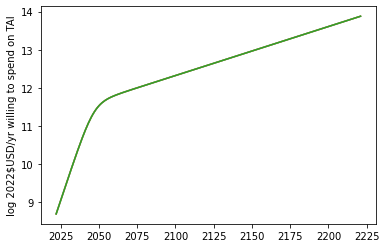

In [21]:
for p in [20, 50, 80]:
    print('-')
    print('-')
    print('## {} ##'.format(p))
    willingness = np.array([willingness_to_pay(initial_gdp=variables['initial_gdp'],
                                               gdp_growth=gdp_growth_p[p],
                                               initial_pay=10 ** initial_pay_p[p],
                                               spend_doubling_time=spend_doubling_time_p[p],
                                               max_gdp_frac=max_gdp_frac_p[p],
                                               year=(y - CURRENT_YEAR)) for y in years])
    for y in years:
        print('Year: {} - willingness log 2022$USD per year {} (~{})'.format(y,
                                                                             np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                                             numerize(np.log10(willingness[y - CURRENT_YEAR]))))


    plt.plot(years, np.log10(willingness))
plt.ylabel('log 2022$USD/yr willing to spend on TAI')
plt.show()


## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

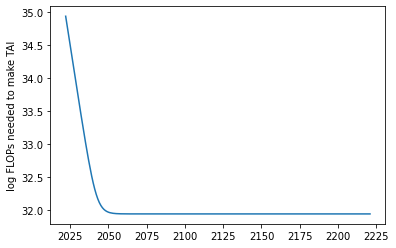

In [22]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                              algo_doubling_rate_max_p[GRAPH_P],
                                                              initial_flops_p[GRAPH_P]),
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [23]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} (~{})'.format(y,
                                                                np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                                numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.9 (~10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.8 (~10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.6 (~10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.5 (~10 decillion)
Year: 2026 - log FLOPs needed for TAI 34.3 (~10 decillion)
Year: 2027 - log FLOPs needed for TAI 34.2 (~10 decillion)
Year: 2028 - log FLOPs needed for TAI 34.0 (~10 decillion)
Year: 2029 - log FLOPs needed for TAI 33.9 (~one decillion)
Year: 2030 - log FLOPs needed for TAI 33.7 (~one decillion)
Year: 2031 - log FLOPs needed for TAI 33.6 (~one decillion)
Year: 2032 - log FLOPs needed for TAI 33.4 (~one decillion)
Year: 2033 - log FLOPs needed for TAI 33.3 (~one decillion)
Year: 2034 - log FLOPs needed for TAI 33.2 (~one decillion)
Year: 2035 - log FLOPs needed for TAI 33.0 (~one decillion)
Year: 2036 - log FLOPs needed for TAI 32.9 (~100 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.8 (~100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.6 (~10

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

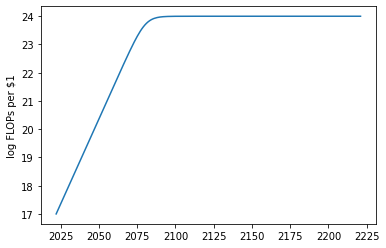

In [24]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [25]:
for y in years:
    print('Year: {} - log {} FLOPs per $ (~{})'.format(y,
                                                       np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.0 FLOPs per $ (~10 quadrillion)
Year: 2023 - log 17.1 FLOPs per $ (~100 quadrillion)
Year: 2024 - log 17.2 FLOPs per $ (~100 quadrillion)
Year: 2025 - log 17.4 FLOPs per $ (~100 quadrillion)
Year: 2026 - log 17.5 FLOPs per $ (~100 quadrillion)
Year: 2027 - log 17.6 FLOPs per $ (~100 quadrillion)
Year: 2028 - log 17.7 FLOPs per $ (~100 quadrillion)
Year: 2029 - log 17.8 FLOPs per $ (~100 quadrillion)
Year: 2030 - log 18.0 FLOPs per $ (~100 quadrillion)
Year: 2031 - log 18.1 FLOPs per $ (~one quintillion)
Year: 2032 - log 18.2 FLOPs per $ (~one quintillion)
Year: 2033 - log 18.3 FLOPs per $ (~one quintillion)
Year: 2034 - log 18.4 FLOPs per $ (~one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (~one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (~one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (~one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (~one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (~10 quintillion)
Year: 2040 - log 19.2 FLOPs per $ (~10 quintilli

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

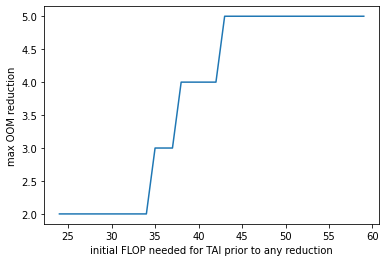

In [26]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                         max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [27]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2)))
          

TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 41 -> 4.0 OOM reductions possible
TAI log FLOP 42 -> 4.0 OOM reductions possible
TAI log FLOP 43 -> 5.0 OOM reductions possible
TAI log FLOP 44 -> 5.0 OOM reductions possible
TAI log FLOP 

## Halving time (years) of compute requirements

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

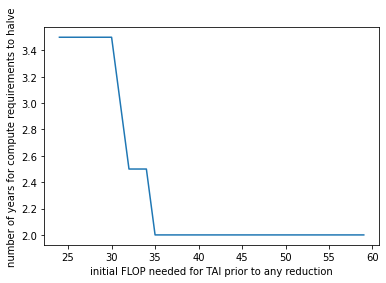

In [28]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                              algo_doubling_rate_max_p[GRAPH_P],
                                              t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('number of years for compute requirements to halve')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [29]:
for t in tai_sizes:
    print('TAI log FLOP {} -> algo doubling rate {}yrs'.format(t,
                                                               round(algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                                     algo_doubling_rate_max_p[GRAPH_P],
                                                                                     t), 2)))


TAI log FLOP 24 -> algo doubling rate 3.5yrs
TAI log FLOP 25 -> algo doubling rate 3.5yrs
TAI log FLOP 26 -> algo doubling rate 3.5yrs
TAI log FLOP 27 -> algo doubling rate 3.5yrs
TAI log FLOP 28 -> algo doubling rate 3.5yrs
TAI log FLOP 29 -> algo doubling rate 3.5yrs
TAI log FLOP 30 -> algo doubling rate 3.5yrs
TAI log FLOP 31 -> algo doubling rate 3.0yrs
TAI log FLOP 32 -> algo doubling rate 2.5yrs
TAI log FLOP 33 -> algo doubling rate 2.5yrs
TAI log FLOP 34 -> algo doubling rate 2.5yrs
TAI log FLOP 35 -> algo doubling rate 2.0yrs
TAI log FLOP 36 -> algo doubling rate 2.0yrs
TAI log FLOP 37 -> algo doubling rate 2.0yrs
TAI log FLOP 38 -> algo doubling rate 2.0yrs
TAI log FLOP 39 -> algo doubling rate 2.0yrs
TAI log FLOP 40 -> algo doubling rate 2.0yrs
TAI log FLOP 41 -> algo doubling rate 2.0yrs
TAI log FLOP 42 -> algo doubling rate 2.0yrs
TAI log FLOP 43 -> algo doubling rate 2.0yrs
TAI log FLOP 44 -> algo doubling rate 2.0yrs
TAI log FLOP 45 -> algo doubling rate 2.0yrs
TAI log FL

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

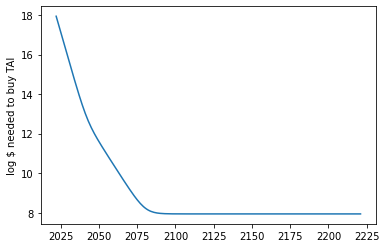

In [30]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                        algo_doubling_rate_max_p[GRAPH_P],
                                                                        initial_flops_p[GRAPH_P]),
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [31]:
for y in years:
    print('Year: {} - log $ {} to buy TAI (~{})'.format(y,
                                                        np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                        numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.9 to buy TAI (~100 quadrillion)
Year: 2023 - log $ 17.7 to buy TAI (~100 quadrillion)
Year: 2024 - log $ 17.4 to buy TAI (~100 quadrillion)
Year: 2025 - log $ 17.1 to buy TAI (~100 quadrillion)
Year: 2026 - log $ 16.9 to buy TAI (~10 quadrillion)
Year: 2027 - log $ 16.6 to buy TAI (~10 quadrillion)
Year: 2028 - log $ 16.3 to buy TAI (~10 quadrillion)
Year: 2029 - log $ 16.0 to buy TAI (~10 quadrillion)
Year: 2030 - log $ 15.8 to buy TAI (~one quadrillion)
Year: 2031 - log $ 15.5 to buy TAI (~one quadrillion)
Year: 2032 - log $ 15.2 to buy TAI (~one quadrillion)
Year: 2033 - log $ 15.0 to buy TAI (~100 trillion)
Year: 2034 - log $ 14.7 to buy TAI (~100 trillion)
Year: 2035 - log $ 14.5 to buy TAI (~100 trillion)
Year: 2036 - log $ 14.2 to buy TAI (~100 trillion)
Year: 2037 - log $ 13.9 to buy TAI (~10 trillion)
Year: 2038 - log $ 13.7 to buy TAI (~10 trillion)
Year: 2039 - log $ 13.5 to buy TAI (~10 trillion)
Year: 2040 - log $ 13.2 to buy TAI (~10 trillion)
Year: 

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

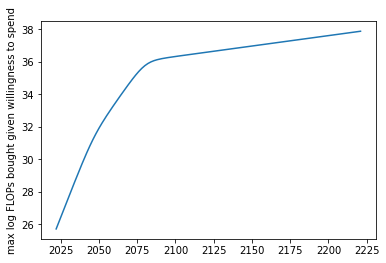

In [32]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=variables['initial_gdp'],
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [33]:
for y in years:
    print('Year: {} - max log FLOPs {} (~{})'.format(y,
                                                     np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                     numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 25.7 (~10 septillion)
Year: 2023 - max log FLOPs 25.9 (~10 septillion)
Year: 2024 - max log FLOPs 26.2 (~100 septillion)
Year: 2025 - max log FLOPs 26.4 (~100 septillion)
Year: 2026 - max log FLOPs 26.7 (~100 septillion)
Year: 2027 - max log FLOPs 26.9 (~100 septillion)
Year: 2028 - max log FLOPs 27.1 (~one octillion)
Year: 2029 - max log FLOPs 27.4 (~one octillion)
Year: 2030 - max log FLOPs 27.6 (~one octillion)
Year: 2031 - max log FLOPs 27.9 (~one octillion)
Year: 2032 - max log FLOPs 28.1 (~10 octillion)
Year: 2033 - max log FLOPs 28.3 (~10 octillion)
Year: 2034 - max log FLOPs 28.6 (~10 octillion)
Year: 2035 - max log FLOPs 28.8 (~10 octillion)
Year: 2036 - max log FLOPs 29.0 (~100 octillion)
Year: 2037 - max log FLOPs 29.3 (~100 octillion)
Year: 2038 - max log FLOPs 29.5 (~100 octillion)
Year: 2039 - max log FLOPs 29.7 (~100 octillion)
Year: 2040 - max log FLOPs 30.0 (~100 octillion)
Year: 2041 - max log FLOPs 30.2 (~one nonillion)
Year: 2042 - max log

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

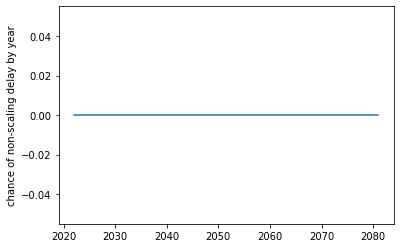

In [34]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(variables.get('initial_chance_of_nonscaling_issue', 0),
                                                   variables.get('final_chance_of_nonscaling_issue', 0),
                                                   year=y,
                                                   max_year=variables.get('nonscaling_issue_bottom_year', 0)) for y in years])

plt.plot(years[:60], p_nonscaling_delay_[:60])
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [35]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 0.0%
Year: 2023 - p(nonscaling delay) = 0.0%
Year: 2024 - p(nonscaling delay) = 0.0%
Year: 2025 - p(nonscaling delay) = 0.0%
Year: 2026 - p(nonscaling delay) = 0.0%
Year: 2027 - p(nonscaling delay) = 0.0%
Year: 2028 - p(nonscaling delay) = 0.0%
Year: 2029 - p(nonscaling delay) = 0.0%
Year: 2030 - p(nonscaling delay) = 0.0%
Year: 2031 - p(nonscaling delay) = 0.0%
Year: 2032 - p(nonscaling delay) = 0.0%
Year: 2033 - p(nonscaling delay) = 0.0%
Year: 2034 - p(nonscaling delay) = 0.0%
Year: 2035 - p(nonscaling delay) = 0.0%
Year: 2036 - p(nonscaling delay) = 0.0%
Year: 2037 - p(nonscaling delay) = 0.0%
Year: 2038 - p(nonscaling delay) = 0.0%
Year: 2039 - p(nonscaling delay) = 0.0%
Year: 2040 - p(nonscaling delay) = 0.0%
Year: 2041 - p(nonscaling delay) = 0.0%
Year: 2042 - p(nonscaling delay) = 0.0%
Year: 2043 - p(nonscaling delay) = 0.0%
Year: 2044 - p(nonscaling delay) = 0.0%
Year: 2045 - p(nonscaling delay) = 0.0%
Year: 2046 - p(nonscaling delay) = 0.0%


## Run Model

It takes 31 log FLOPs (~10 nonillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.0 log 2022$USD (~10 million) and this increases by 3x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.025x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.0 max log FLOP (one septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 7.0 (one million) - 18.0 log FLOPS per $ (100 quadrillion)
Year: 2023 - 25.3 max log FLOP (10 septillion) available - TAI takes 30

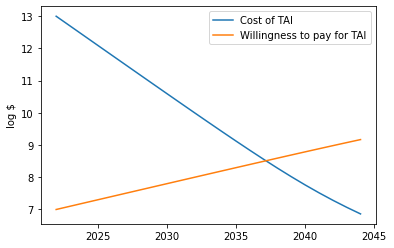

2044

In [36]:
def run_model(initial_gdp_, tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
              possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
              max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
              willingness_ramp_, spend_doubling_time_, initial_chance_of_nonscaling_issue_,
              final_chance_of_nonscaling_issue_, nonscaling_issue_bottom_year_,
              willingness_spend_horizon_, print_diagnostic):
    queue_tai_year = 99999
    plt.ioff()
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if print_diagnostic:
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               numerize(math.log10(initial_flops_per_dollar_)),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        else:
            print('In this simulation, there are no willingness ramp effects.')
        print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    for y in years:
        if not tai_created:
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_
            
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp_,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            if print_diagnostic:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_
                
            if not is_nonscaling_issue and queue_tai_year < 99999 and print_diagnostic:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_) <= willingness_ or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    return y
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if print_diagnostic:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        return MAX_YEAR + 1

    
run_model(initial_gdp_ = 21 * trillion,
          tai_flop_size_=31,
          nonscaling_delay_=6,
          algo_doubling_rate_=2,
          possible_algo_reduction_=3,
          initial_flops_per_dollar_=10 ** 18,
          flops_halving_rate_=2,
          max_flops_per_dollar_=10 ** 24,
          initial_pay_=10 ** 7,
          gdp_growth_=1.025,
          max_gdp_frac_=0.0005,
          willingness_ramp_=1,
          spend_doubling_time_=3,
          initial_chance_of_nonscaling_issue_=0.9,
          final_chance_of_nonscaling_issue_=0.1,
          nonscaling_issue_bottom_year_=2050,
          willingness_spend_horizon_=10,
          print_diagnostic=True)
    

Running
## RUN 1/10000 ##
It takes 67.2 log FLOPs (~10 decillion decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 5 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 67.2 log FLOP (10 decillion decillion) - log $ 50.2 to buy TAI (100 quadrillion decillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023

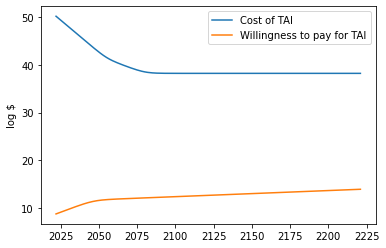

## RUN 2/10000 ##
It takes 36.4 log FLOPs (~one thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 36.4 log FLOP (one thousand decillion) - log $ 19.4 to buy TAI (10 quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLO

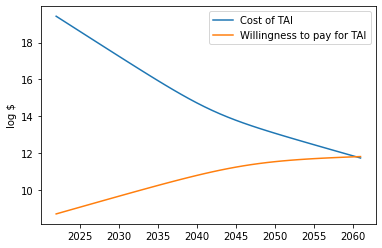

## RUN 3/10000 ##
It takes 32.0 log FLOPs (~100 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 15.0 to buy TAI (one quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillio

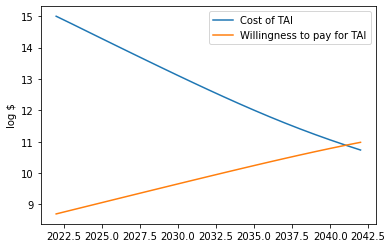

## RUN 4/10000 ##
It takes 33.9 log FLOPs (~one decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 33.9 log FLOP (one decillion) - log $ 16.9 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion

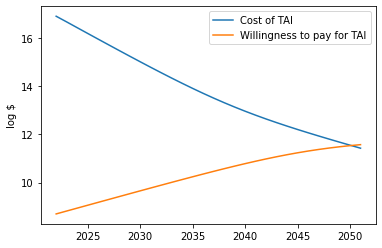

## RUN 5/10000 ##
It takes 33.3 log FLOPs (~one decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 33.3 log FLOP (one decillion) - log $ 16.3 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion

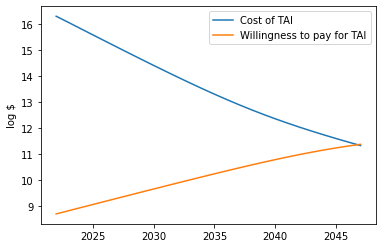

## RUN 6/10000 ##
It takes 65.5 log FLOPs (~100 nonillion decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 5 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 65.5 log FLOP (100 nonillion decillion) - log $ 48.5 to buy TAI (one quadrillion decillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.

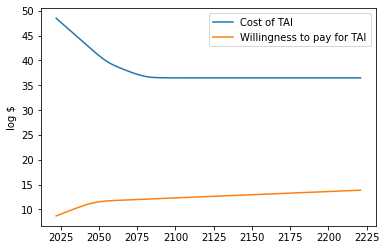

## RUN 7/10000 ##
It takes 35.7 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 35.7 log FLOP (100 decillion) - log $ 18.7 to buy TAI (one quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillio

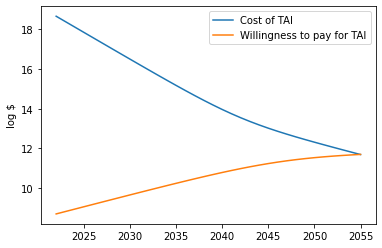

## RUN 8/10000 ##
It takes 37.0 log FLOPs (~one thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 37.0 log FLOP (one thousand decillion) - log $ 20.0 to buy TAI (10 quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLO

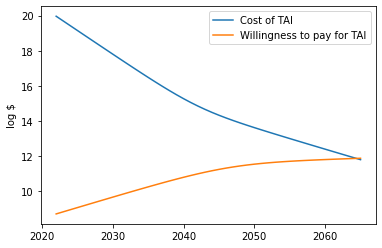

## RUN 9/10000 ##
It takes 38.5 log FLOPs (~100 thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 4 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 38.5 log FLOP (100 thousand decillion) - log $ 21.5 to buy TAI (one sextillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLO

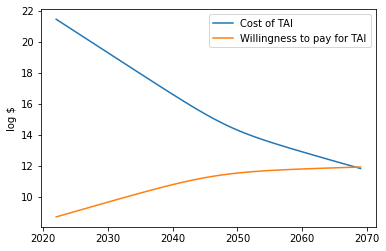

## RUN 10/10000 ##
It takes 37.5 log FLOPs (~10 thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 37.5 log FLOP (10 thousand decillion) - log $ 20.5 to buy TAI (100 quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLO

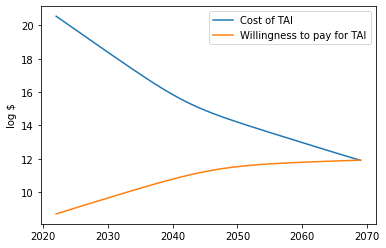

## RUN 11/10000 ##
It takes 29.5 log FLOPs (~100 octillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 29.5 log FLOP (100 octillion) - log $ 12.5 to buy TAI (one trillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion)

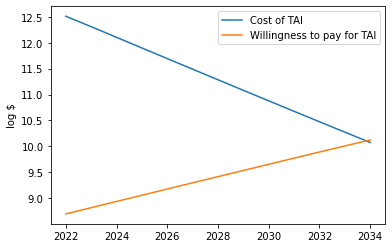

## RUN 12/10000 ##
It takes 28.8 log FLOPs (~10 octillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 28.8 log FLOP (10 octillion) - log $ 11.8 to buy TAI (100 billion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion) av

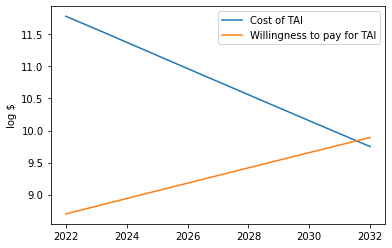

## RUN 13/10000 ##
It takes 26.3 log FLOPs (~100 septillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 26.3 log FLOP (100 septillion) - log $ 9.3 to buy TAI (one billion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion)

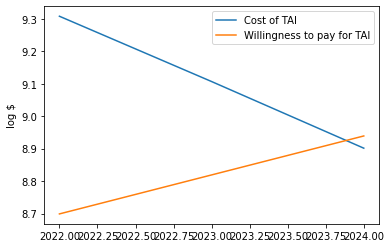

## RUN 14/10000 ##
It takes 34.8 log FLOPs (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 34.8 log FLOP (10 decillion) - log $ 17.8 to buy TAI (100 quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion

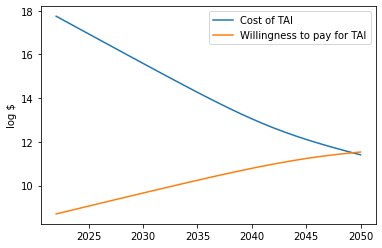

## RUN 15/10000 ##
It takes 39.2 log FLOPs (~one million decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 4 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 39.2 log FLOP (one million decillion) - log $ 22.2 to buy TAI (10 sextillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP 

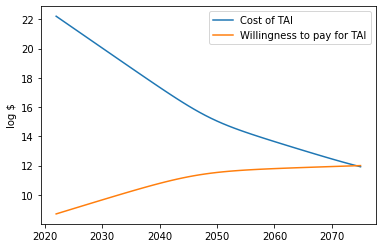

## RUN 16/10000 ##
It takes 35.2 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 35.2 log FLOP (100 decillion) - log $ 18.2 to buy TAI (one quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septilli

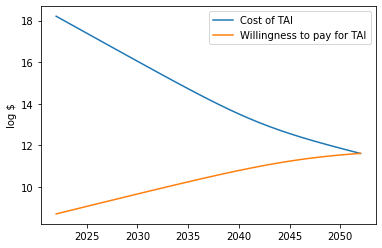

## RUN 17/10000 ##
It takes 32.9 log FLOPs (~100 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 32.9 log FLOP (100 nonillion) - log $ 15.9 to buy TAI (one quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septilli

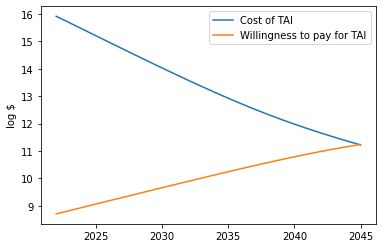

## RUN 18/10000 ##
It takes 39.6 log FLOPs (~one million decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 4 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 39.6 log FLOP (one million decillion) - log $ 22.6 to buy TAI (10 sextillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP 

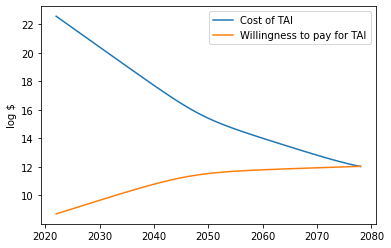

## RUN 19/10000 ##
It takes 33.6 log FLOPs (~one decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 33.6 log FLOP (one decillion) - log $ 16.6 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillio

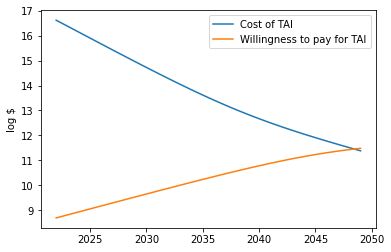

## RUN 20/10000 ##
It takes 25.8 log FLOPs (~10 septillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 25.8 log FLOP (10 septillion) - log $ 8.8 to buy TAI (100 million) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion) a

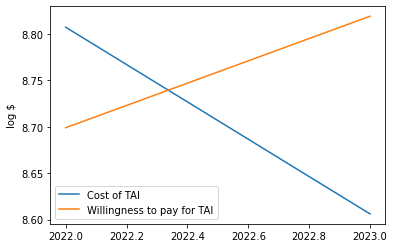

## RUN 21/10000 ##
It takes 35.8 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 35.8 log FLOP (100 decillion) - log $ 18.8 to buy TAI (one quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septilli

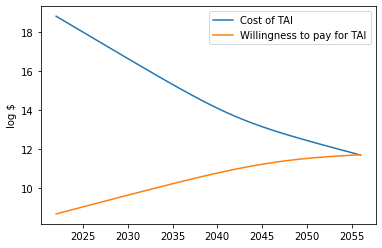

## RUN 22/10000 ##
It takes 28.1 log FLOPs (~10 octillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 28.1 log FLOP (10 octillion) - log $ 11.1 to buy TAI (100 billion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion) av

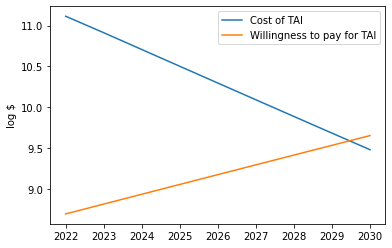

## RUN 23/10000 ##
It takes 36.8 log FLOPs (~one thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 36.8 log FLOP (one thousand decillion) - log $ 19.8 to buy TAI (10 quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FL

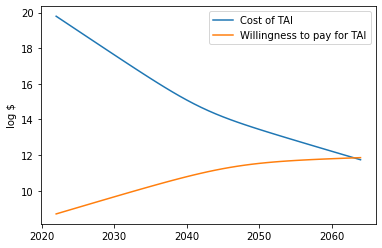

## RUN 24/10000 ##
It takes 28.0 log FLOPs (~one octillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 28.0 log FLOP (one octillion) - log $ 11.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion) a

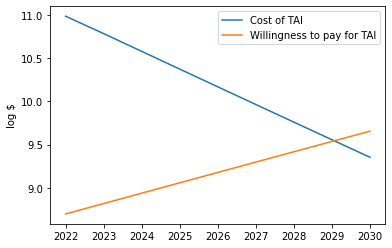

## RUN 25/10000 ##
It takes 34.4 log FLOPs (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 34.4 log FLOP (10 decillion) - log $ 17.4 to buy TAI (100 quadrillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion

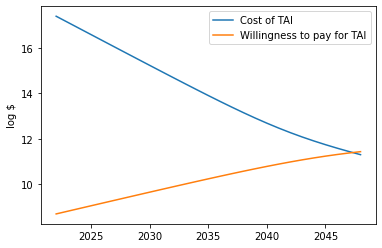

## RUN 26/10000 ##
It takes 35.2 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 35.2 log FLOP (100 decillion) - log $ 18.2 to buy TAI (one quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septilli

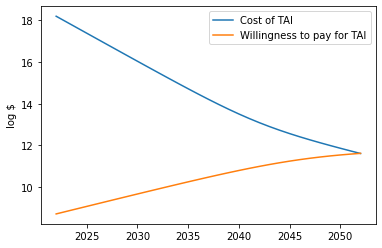

## RUN 27/10000 ##
It takes 35.0 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 18.0 to buy TAI (one quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septilli

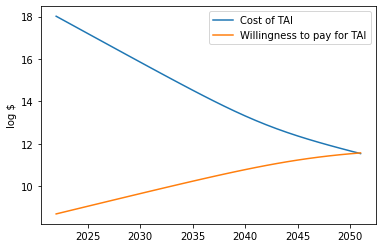

## RUN 28/10000 ##
It takes 36.1 log FLOPs (~one thousand decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 36.1 log FLOP (one thousand decillion) - log $ 19.1 to buy TAI (10 quintillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FL

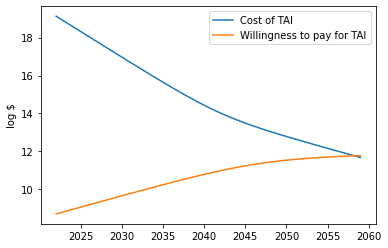

## RUN 29/10000 ##
It takes 28.1 log FLOPs (~10 octillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 28.1 log FLOP (10 octillion) - log $ 11.1 to buy TAI (100 billion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP (10 septillion) av

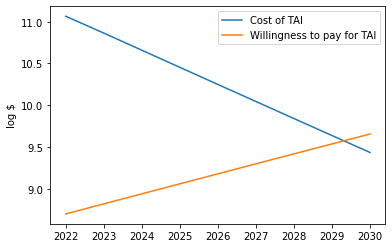

## RUN 30/10000 ##
It takes 39.1 log FLOPs (~one million decillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 4 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~100 million) and this increases by 2.5x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 1 years to make TAI
If a non-scaling delay happens, it will take an additional 0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.7 max log FLOP (10 septillion) available - TAI takes 39.1 log FLOP (one million decillion) - log $ 22.1 to buy TAI (10 sextillion) vs. willingness to pay log $ 8.7 (100 million) - 17.0 log FLOPS per $ (10 quadrillion)
Year: 2023 - 25.9 max log FLOP 

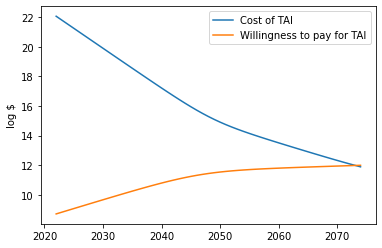

## RUN 201/10000 ##
## RUN 401/10000 ##
## RUN 601/10000 ##
## RUN 801/10000 ##
## RUN 1001/10000 ##
## RUN 1201/10000 ##
## RUN 1401/10000 ##
## RUN 1601/10000 ##
## RUN 1801/10000 ##
## RUN 2001/10000 ##
## RUN 2201/10000 ##
## RUN 2401/10000 ##
## RUN 2601/10000 ##
## RUN 2801/10000 ##
## RUN 3001/10000 ##
## RUN 3201/10000 ##
## RUN 3401/10000 ##
## RUN 3601/10000 ##
## RUN 3801/10000 ##
## RUN 4001/10000 ##
## RUN 4201/10000 ##
## RUN 4401/10000 ##
## RUN 4601/10000 ##
## RUN 4801/10000 ##
## RUN 5001/10000 ##
## RUN 5201/10000 ##
## RUN 5401/10000 ##
## RUN 5601/10000 ##
## RUN 5801/10000 ##
## RUN 6001/10000 ##
## RUN 6201/10000 ##
## RUN 6401/10000 ##
## RUN 6601/10000 ##
## RUN 6801/10000 ##
## RUN 7001/10000 ##
## RUN 7201/10000 ##
## RUN 7401/10000 ##
## RUN 7601/10000 ##
## RUN 7801/10000 ##
## RUN 8001/10000 ##
## RUN 8201/10000 ##
## RUN 8401/10000 ##
## RUN 8601/10000 ##
## RUN 8801/10000 ##
## RUN 9001/10000 ##
## RUN 9201/10000 ##
## RUN 9401/10000 ##
## RUN 9601/10000

In [37]:
print('Running')

def loop_model(r):
    print_diagnostic = r < 30
    if print_diagnostic or r % 200 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    
    tai_flop_size_ = sample(variables['tai_flop_size'])
    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sample(variables['algo_doubling_rate_min']),
                                          sample(variables['algo_doubling_rate_max']),
                                          tai_flop_size_)
    
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(variables['min_reduction']),
                                                          sample(variables['max_reduction']),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(variables['initial_flops_per_dollar'])
    flops_halving_rate_ = sample(variables['flops_halving_rate'])
    max_flops_per_dollar_ = 10 ** sample(variables['max_flops_per_dollar'])
    initial_pay_ = 10 ** sample(variables['initial_pay'])
    gdp_growth_ = sample(variables['gdp_growth'])
    max_gdp_frac_ = sample(variables['max_gdp_frac'])
    
    willingness_ramp_happens = event_occurs(variables.get('p_willingness_ramp', 0))
    if willingness_ramp_happens:
        willingness_ramp_ = sample(variables.get('willingness_ramp', 1))
    else:
        willingness_ramp_ = 1
    
    initial_gdp_ = variables['initial_gdp']
    spend_doubling_time_ = sample(variables['spend_doubling_time'])
    nonscaling_delay_ = sample(variables.get('nonscaling_delay', const(0)))
    initial_chance_of_nonscaling_issue_ = variables.get('initial_chance_of_nonscaling_issue', 0)
    final_chance_of_nonscaling_issue_ = variables.get('final_chance_of_nonscaling_issue', 0)
    nonscaling_issue_bottom_year_ = variables.get('nonscaling_issue_bottom_year', 0)
    willingness_spend_horizon_ = int(sample(variables.get('willingness_spend_horizon', const(1))))
    
    return run_model(initial_gdp_=initial_gdp_,
                     tai_flop_size_=tai_flop_size_,
                     nonscaling_delay_=nonscaling_delay_,
                     algo_doubling_rate_=algo_doubling_rate_,
                     possible_algo_reduction_=possible_algo_reduction_,
                     initial_flops_per_dollar_=initial_flops_per_dollar_,
                     flops_halving_rate_=flops_halving_rate_,
                     max_flops_per_dollar_=max_flops_per_dollar_,
                     initial_pay_=initial_pay_,
                     gdp_growth_=gdp_growth_,
                     max_gdp_frac_=max_gdp_frac_,
                     willingness_ramp_=willingness_ramp_,
                     spend_doubling_time_=spend_doubling_time_,
                     initial_chance_of_nonscaling_issue_=initial_chance_of_nonscaling_issue_,
                     final_chance_of_nonscaling_issue_=final_chance_of_nonscaling_issue_,
                     nonscaling_issue_bottom_year_=nonscaling_issue_bottom_year_,
                     willingness_spend_horizon_=willingness_spend_horizon_,
                     print_diagnostic=print_diagnostic)

tai_years = [loop_model(r) for r in range(RUNS)]

In [38]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Aug 27 8:43PM CT):
# '1%: 2024',
# '5%: 2027',
# '10%: 2029',
# '20%: 2033',
# '30%: 2038',
# '40%: 2045',
# '50%: 2054',
# '60%: 2064',
# '70%: 2079',
# '80%: 2116',
# '90%: >2222',
# '95%: >2222',
# '99%: >2222']


['1%: 2024',
 '5%: 2028',
 '10%: 2031',
 '20%: 2037',
 '30%: 2042',
 '40%: 2047',
 '50%: 2052',
 '60%: 2063',
 '70%: 2071',
 '80%: 2137',
 '90%: >2222',
 '95%: >2222',
 '99%: >2222']

In [39]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['1%: 2 years from now',
 '5%: 6 years from now',
 '10%: 9 years from now',
 '20%: 15 years from now',
 '30%: 20 years from now',
 '40%: 25 years from now',
 '50%: 30 years from now',
 '60%: 41 years from now',
 '70%: 49 years from now',
 '80%: 115 years from now',
 '90%: >200 years from now',
 '95%: >200 years from now',
 '99%: >200 years from now']

In [40]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2022)


## Within <1 years


'1% chance of TAI by EOY 2022'

In [41]:
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2023)

## Within <1 years


'1% chance of TAI by EOY 2023'

In [42]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [43]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [44]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [45]:
print_chance_tai_by_year(tai_years, 2029)

'7% chance of TAI by EOY 2029'

In [46]:
print_chance_tai_by_year(tai_years, 2030)

'9% chance of TAI by EOY 2030'

In [47]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'12% chance of TAI by EOY 2032'

In [48]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'19% chance of TAI by EOY 2036'

In [49]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'21% chance of TAI by EOY 2037'

In [50]:
print_chance_tai_by_year(tai_years, 2040)

'26% chance of TAI by EOY 2040'

In [51]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'31% chance of TAI by EOY 2042'

In [52]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'40% chance of TAI by EOY 2047'

In [53]:
print_chance_tai_by_year(tai_years, 2050)

'48% chance of TAI by EOY 2050'

In [54]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'58% chance of TAI by EOY 2060'

In [55]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'69% chance of TAI by EOY 2070'

In [56]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'72% chance of TAI by EOY 2072'

In [57]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'75% chance of TAI by EOY 2078'

In [58]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'78% chance of TAI by EOY 2097'

In [59]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'78% chance of TAI by EOY 2100'

In [60]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'79% chance of TAI by EOY 2122'

In [61]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'85% chance of TAI by EOY 2222'

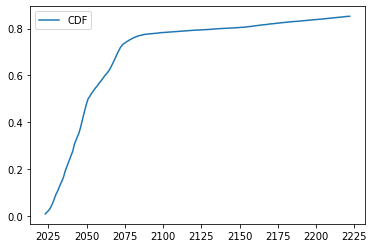

In [62]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

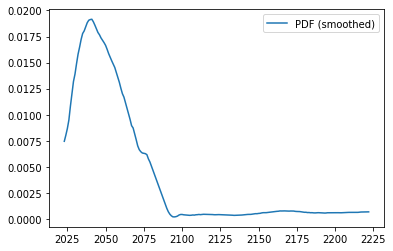

In [63]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [64]:
cdf[:len(bins)]

array([0.0076, 0.0148, 0.0212, 0.0291, 0.0418, 0.0565, 0.0735, 0.0917,
       0.1042, 0.1206, 0.1361, 0.1502, 0.1668, 0.1908, 0.2082, 0.2245,
       0.2437, 0.2607, 0.2769, 0.3051, 0.3219, 0.3377, 0.353 , 0.376 ,
       0.4026, 0.4288, 0.4557, 0.4795, 0.4997, 0.509 , 0.5211, 0.5295,
       0.5391, 0.5476, 0.555 , 0.5651, 0.5727, 0.5817, 0.5914, 0.5991,
       0.6068, 0.6148, 0.6244, 0.6364, 0.6494, 0.6633, 0.6781, 0.6921,
       0.7048, 0.7177, 0.7269, 0.7338, 0.7385, 0.743 , 0.747 , 0.751 ,
       0.7544, 0.7579, 0.7616, 0.7637, 0.7669, 0.7688, 0.7708, 0.7718,
       0.7735, 0.7751, 0.7756, 0.7765, 0.7773, 0.7779, 0.7783, 0.7792,
       0.7796, 0.7802, 0.7812, 0.7821, 0.7826, 0.7831, 0.7832, 0.7839,
       0.785 , 0.7855, 0.7858, 0.7861, 0.7864, 0.7869, 0.7877, 0.7882,
       0.789 , 0.7893, 0.7898, 0.7902, 0.7907, 0.7911, 0.7915, 0.7917,
       0.7923, 0.7927, 0.7932, 0.7933, 0.7939, 0.7942, 0.7949, 0.7954,
       0.7956, 0.7957, 0.7963, 0.797 , 0.7973, 0.7978, 0.7984, 0.7989,
      

In [65]:
pdf[:len(bins)]

array([0.0076, 0.0072, 0.0064, 0.0079, 0.0127, 0.0147, 0.017 , 0.0182,
       0.0125, 0.0164, 0.0155, 0.0141, 0.0166, 0.024 , 0.0174, 0.0163,
       0.0192, 0.017 , 0.0162, 0.0282, 0.0168, 0.0158, 0.0153, 0.023 ,
       0.0266, 0.0262, 0.0269, 0.0238, 0.0202, 0.0093, 0.0121, 0.0084,
       0.0096, 0.0085, 0.0074, 0.0101, 0.0076, 0.009 , 0.0097, 0.0077,
       0.0077, 0.008 , 0.0096, 0.012 , 0.013 , 0.0139, 0.0148, 0.014 ,
       0.0127, 0.0129, 0.0092, 0.0069, 0.0047, 0.0045, 0.004 , 0.004 ,
       0.0034, 0.0035, 0.0037, 0.0021, 0.0032, 0.0019, 0.002 , 0.001 ,
       0.0017, 0.0016, 0.0005, 0.0009, 0.0008, 0.0006, 0.0004, 0.0009,
       0.0004, 0.0006, 0.001 , 0.0009, 0.0005, 0.0005, 0.0001, 0.0007,
       0.0011, 0.0005, 0.0003, 0.0003, 0.0003, 0.0005, 0.0008, 0.0005,
       0.0008, 0.0003, 0.0005, 0.0004, 0.0005, 0.0004, 0.0004, 0.0002,
       0.0006, 0.0004, 0.0005, 0.0001, 0.0006, 0.0003, 0.0007, 0.0005,
       0.0002, 0.0001, 0.0006, 0.0007, 0.0003, 0.0005, 0.0006, 0.0005,
      

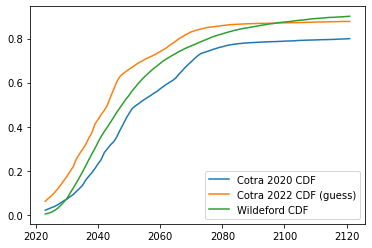

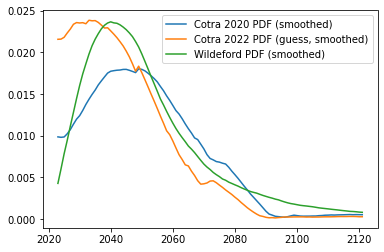

In [66]:
## TODO: Update all

cotra_2020_cdf = [0.0214, 0.0272, 0.0328, 0.0385, 0.0458, 0.0551, 0.0641, 0.0721,
       0.0827, 0.0923, 0.1061, 0.1199, 0.1343, 0.1574, 0.175 , 0.1917,
       0.2108, 0.2321, 0.251 , 0.2825, 0.3001, 0.3177, 0.3317, 0.3531,
       0.3829, 0.4089, 0.4372, 0.4606, 0.4829, 0.4944, 0.504 , 0.5147,
       0.5243, 0.5335, 0.5423, 0.5521, 0.5608, 0.5719, 0.5826, 0.5922,
       0.6011, 0.6096, 0.6209, 0.6379, 0.6524, 0.6682, 0.682 , 0.6948,
       0.7084, 0.7207, 0.7314, 0.7362, 0.7407, 0.7456, 0.7506, 0.755 ,
       0.7594, 0.7626, 0.7668, 0.7698, 0.7725, 0.7745, 0.7765, 0.7775,
       0.7793, 0.7801, 0.781 , 0.7818, 0.7827, 0.7833, 0.7843, 0.7847,
       0.7852, 0.7858, 0.7861, 0.7868, 0.7874, 0.7882, 0.7887, 0.7891,
       0.7895, 0.7908, 0.7916, 0.7918, 0.7926, 0.7929, 0.7933, 0.7936,
       0.7941, 0.7949, 0.795 , 0.7954, 0.7957, 0.7962, 0.7969, 0.7976,
       0.7981, 0.7987, 0.7996, 0.8002, 0.8004, 0.801 , 0.8015, 0.8021,
       0.8025, 0.8029, 0.8034, 0.8041, 0.8045, 0.8052, 0.8059, 0.806 ,
       0.8066, 0.8071, 0.8079, 0.8087, 0.8089, 0.8093, 0.8093, 0.8095,
       0.8105, 0.8109, 0.8114, 0.8118, 0.8128, 0.8132, 0.8139, 0.8139,
       0.8144, 0.8149, 0.8154, 0.8162, 0.8167, 0.8173, 0.8177, 0.8185,
       0.8196, 0.82  , 0.821 , 0.8217, 0.8224, 0.8233, 0.8244, 0.8247,
       0.8254, 0.8262, 0.8267, 0.8274, 0.8277, 0.8288, 0.8294, 0.8298,
       0.8305, 0.8318, 0.8328, 0.8335, 0.8343, 0.8347, 0.8351, 0.8361,
       0.837 , 0.8376, 0.8385, 0.8398, 0.8404, 0.8413, 0.8419, 0.8427,
       0.8437, 0.8448, 0.8458, 0.8462, 0.8471, 0.8482, 0.8487, 0.8491,
       0.8498, 0.8505, 0.8507, 0.8511, 0.8519, 0.8526, 0.8534, 0.8542,
       0.855 , 0.8554, 0.8559, 0.8565, 0.857 , 0.8575, 0.8581, 0.8587,
       0.8592, 0.86  , 0.8605, 0.861 , 0.8615, 0.862 , 0.8629]
cotra_2020_pdf = np.append(np.array(cotra_2020_cdf[0]), np.diff(cotra_2020_cdf[:len(bins)]))
cotra_2020_pdf_smoothed = savitzky_golay(cotra_2020_pdf[:len(bins)], 51, 3)

cotra_2022_cdf = [0.0616, 0.0747, 0.0873, 0.1015, 0.118 , 0.1365, 0.1564, 0.1758,
       0.1981, 0.2188, 0.2531, 0.2768, 0.2975, 0.3193, 0.3481, 0.3728,
       0.4124, 0.433 , 0.4557, 0.4742, 0.4981, 0.5348, 0.569 , 0.6032,
       0.627 , 0.6404, 0.6507, 0.6611, 0.6701, 0.6801, 0.6893, 0.697 ,
       0.7051, 0.7115, 0.7186, 0.7252, 0.7331, 0.7411, 0.749 , 0.7577,
       0.7691, 0.7785, 0.7881, 0.799 , 0.807 , 0.8161, 0.8233, 0.8303,
       0.8348, 0.839 , 0.8429, 0.8462, 0.8494, 0.8517, 0.8532, 0.8553,
       0.8566, 0.8588, 0.8602, 0.862 , 0.8633, 0.864 , 0.8648, 0.8654,
       0.8662, 0.867 , 0.8672, 0.8677, 0.8683, 0.8686, 0.8689, 0.8689,
       0.8692, 0.8695, 0.8699, 0.8703, 0.8709, 0.8711, 0.8713, 0.8715,
       0.8719, 0.8721, 0.8727, 0.873 , 0.8736, 0.8739, 0.8742, 0.8746,
       0.875 , 0.8751, 0.8754, 0.8757, 0.8763, 0.8764, 0.8768, 0.8772,
       0.8775, 0.8775, 0.8776, 0.8779, 0.878 , 0.8781, 0.8783, 0.8789,
       0.8792, 0.8794, 0.8795, 0.8798, 0.8805, 0.8808, 0.8814, 0.8819,
       0.8822, 0.8826, 0.8827, 0.8828, 0.8832, 0.8834, 0.8837, 0.8839,
       0.8842, 0.8848, 0.8857, 0.8859, 0.8861, 0.8863, 0.8866, 0.8869,
       0.8869, 0.8873, 0.8878, 0.8889, 0.8896, 0.8904, 0.8906, 0.8911,
       0.8915, 0.892 , 0.8929, 0.8934, 0.8937, 0.8942, 0.8946, 0.8954,
       0.8959, 0.8963, 0.8969, 0.8972, 0.8975, 0.8984, 0.8988, 0.8993,
       0.8999, 0.9004, 0.9007, 0.9015, 0.9019, 0.9021, 0.9026, 0.9031,
       0.9037, 0.9041, 0.9048, 0.9054, 0.9057, 0.9062, 0.9067, 0.9075,
       0.9084, 0.9088, 0.909 , 0.9101, 0.9106, 0.9108, 0.9114, 0.9116,
       0.9121, 0.9127, 0.913 , 0.9137, 0.9144, 0.9147, 0.9154, 0.9159,
       0.9161, 0.9166, 0.9173, 0.9177, 0.9185, 0.9189, 0.9193, 0.9195,
       0.9195, 0.9198, 0.9204, 0.9205, 0.921 , 0.9216, 0.9221]
cotra_2022_pdf = np.append(np.array(cotra_2022_cdf[0]), np.diff(cotra_2022_cdf[:len(bins)]))
cotra_2022_pdf_smoothed = savitzky_golay(cotra_2022_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0044, 0.0074, 0.0124, 0.0203, 0.03  , 0.0438, 0.0586, 0.0752,
       0.0991, 0.1215, 0.1453, 0.17  , 0.1955, 0.2222, 0.2498, 0.2768,
       0.302 , 0.33  , 0.3559, 0.378 , 0.3989, 0.4204, 0.4421, 0.465 ,
       0.4854, 0.5055, 0.5258, 0.5428, 0.5632, 0.5798, 0.5972, 0.6127,
       0.6272, 0.6401, 0.6532, 0.6653, 0.6759, 0.6875, 0.6987, 0.7075,
       0.7161, 0.7244, 0.732 , 0.7404, 0.7472, 0.7549, 0.7607, 0.7669,
       0.7727, 0.7788, 0.7851, 0.7909, 0.7965, 0.8024, 0.808 , 0.8128,
       0.8174, 0.8212, 0.8256, 0.8297, 0.8335, 0.8372, 0.8405, 0.8436,
       0.8462, 0.8487, 0.851 , 0.8537, 0.8556, 0.8586, 0.861 , 0.8629,
       0.8659, 0.8672, 0.8692, 0.872 , 0.8732, 0.8749, 0.8762, 0.8778,
       0.8797, 0.8815, 0.8829, 0.8841, 0.8857, 0.8878, 0.8896, 0.8905,
       0.8916, 0.8928, 0.894 , 0.8952, 0.896 , 0.8964, 0.8975, 0.8981,
       0.8989, 0.8999, 0.9011, 0.9018, 0.9025, 0.9028, 0.9034, 0.9041,
       0.9047, 0.9052, 0.9055, 0.9058, 0.9061, 0.9074, 0.9081, 0.9087,
       0.9095, 0.9103, 0.911 , 0.9113, 0.9118, 0.912 , 0.9126, 0.9127,
       0.913 , 0.9133, 0.9136, 0.9147, 0.915 , 0.9152, 0.9155, 0.9159,
       0.9161, 0.9167, 0.9168, 0.9168, 0.9175, 0.9177, 0.9182, 0.9188,
       0.9194, 0.9196, 0.9198, 0.9201, 0.9205, 0.9207, 0.9208, 0.9211,
       0.9213, 0.9217, 0.9222, 0.9228, 0.9231, 0.9234, 0.9234, 0.9235,
       0.9239, 0.9242, 0.9245, 0.9248, 0.9251, 0.9251, 0.9253, 0.9261,
       0.9267, 0.927 , 0.927 , 0.9274, 0.9277, 0.9282, 0.9283, 0.9287,
       0.9288, 0.9291, 0.9292, 0.9295, 0.9296, 0.9296, 0.9297, 0.9302,
       0.9306, 0.931 , 0.9313, 0.9318, 0.932 , 0.932 , 0.9323, 0.9327,
       0.933 , 0.9336, 0.934 , 0.9342, 0.9345, 0.9349, 0.935 , 0.9352,
       0.9353, 0.9355, 0.9356, 0.9358, 0.9358, 0.936 , 0.9363]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], cotra_2020_cdf[:99], label='Cotra 2020 CDF')
plt.plot(bins[:99], cotra_2022_cdf[:99], label='Cotra 2022 CDF (guess)')
plt.plot(bins[:99], peter_cdf[:99], label='Wildeford CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], cotra_2020_pdf_smoothed[:99], label='Cotra 2020 PDF (smoothed)')
plt.plot(bins[:99], cotra_2022_pdf_smoothed[:99], label='Cotra 2022 PDF (guess, smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Wildeford PDF (smoothed)')
plt.legend()
plt.show()

## Sensitivity Analysis

In [67]:
print('## Horizon Length ##')
for t in range(0, 10):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=sample_cotra_anchor(horizon_length=const(t)),
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
          

## Horizon Length ##
0: [2022, 2031, 2166]
1: [2022, 2034, 2194]
2: [2022, 2035, 2221]
3: [2024, 2039, '>2222']
4: [2025, 2043, '>2222']
5: [2027, 2046, '>2222']
6: [2028, 2049, '>2222']
7: [2032, 2057, '>2222']
8: [2033, 2065, '>2222']
9: [2036, 2089, '>2222']


In [68]:
print('## Horizon Length - no Bayes Update ##')
for t in range(0, 10):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=sample_cotra_anchor(horizon_length=const(t),
                                                                          bayes_update=None),
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
          

## Horizon Length - no Bayes Update ##
0: [2022, 2031, 2078]
1: [2022, 2034, 2143]
2: [2022, 2036, '>2222']
3: [2022, 2038, '>2222']
4: [2024, 2042, '>2222']
5: [2027, 2046, '>2222']
6: [2029, 2050, '>2222']
7: [2032, 2056, '>2222']
8: [2033, 2065, '>2222']
9: [2037, 2079, '>2222']


In [69]:
print('## TAI FLOP Size ##')
for t in range(20, 51):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=t,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## TAI FLOP Size ##
20: [2022, 2022, 2022]
21: [2022, 2022, 2022]
22: [2022, 2022, 2022]
23: [2022, 2022, 2022]
24: [2022, 2022, 2022]
25: [2022, 2022, 2022]
26: [2022, 2022, 2022]
27: [2023, 2023, 2023]
28: [2026, 2026, 2026]
29: [2028, 2028, 2028]
30: [2031, 2031, 2031]
31: [2034, 2034, 2034]
32: [2036, 2036, 2036]
33: [2039, 2039, 2039]
34: [2042, 2042, 2042]
35: [2046, 2046, 2046]
36: [2051, 2051, 2051]
37: [2058, 2058, 2058]
38: [2066, 2066, 2066]
39: [2080, 2080, 2080]
40: [2153, 2153, 2153]
41: ['>2222', '>2222', '>2222']
42: ['>2222', '>2222', '>2222']
43: ['>2222', '>2222', '>2222']
44: ['>2222', '>2222', '>2222']
45: ['>2222', '>2222', '>2222']
46: ['>2222', '>2222', '>2222']
47: ['>2222', '>2222', '>2222']
48: ['>2222', '>2222', '>2222']
49: ['>2222', '>2222', '>2222']
50: ['>2222', '>2222', '>2222']


In [70]:
print('## GDP Growth ##')
for g in range(0, 5):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1 + g / 100,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + g / 100,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## GDP Growth ##
1.0: [2053, 2053, 2053]
1.01: [2053, 2053, 2053]
1.02: [2052, 2052, 2052]
1.03: [2051, 2051, 2051]
1.04: [2051, 2051, 2051]


In [71]:
print('## Max GDP Frac ##')
for g in [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02]:
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=g,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(g,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## Max GDP Frac ##
0.0001: [2066, 2066, 2066]
0.0005: [2060, 2060, 2060]
0.001: [2058, 2058, 2058]
0.002: [2055, 2055, 2055]
0.003: [2054, 2054, 2054]
0.004: [2053, 2053, 2053]
0.005: [2053, 2053, 2053]
0.01: [2051, 2051, 2051]
0.02: [2050, 2050, 2050]


In [72]:
print('## Spend Doubling Time ##')
for d in range(0, 50):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=1 + d / 10,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + d / 10,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## Spend Doubling Time ##
1.0: [2050, 2050, 2050]
1.1: [2050, 2050, 2050]
1.2: [2050, 2050, 2050]
1.3: [2050, 2050, 2050]
1.4: [2050, 2050, 2050]
1.5: [2050, 2050, 2050]
1.6: [2050, 2050, 2050]
1.7: [2050, 2050, 2050]
1.8: [2050, 2050, 2050]
1.9: [2050, 2050, 2050]
2.0: [2050, 2050, 2050]
2.1: [2051, 2051, 2051]
2.2: [2051, 2051, 2051]
2.3: [2051, 2051, 2051]
2.4: [2051, 2051, 2051]
2.5: [2051, 2051, 2051]
2.6: [2051, 2051, 2051]
2.7: [2052, 2052, 2052]
2.8: [2052, 2052, 2052]
2.9: [2052, 2052, 2052]
3.0: [2052, 2052, 2052]
3.1: [2053, 2053, 2053]
3.2: [2053, 2053, 2053]
3.3: [2053, 2053, 2053]
3.4: [2054, 2054, 2054]
3.5: [2054, 2054, 2054]
3.6: [2054, 2054, 2054]
3.7: [2054, 2054, 2054]
3.8: [2055, 2055, 2055]
3.9: [2055, 2055, 2055]
4.0: [2055, 2055, 2055]
4.1: [2056, 2056, 2056]
4.2: [2056, 2056, 2056]
4.3: [2056, 2056, 2056]
4.4: [2056, 2056, 2056]
4.5: [2057, 2057, 2057]
4.6: [2057, 2057, 2057]
4.7: [2057, 2057, 2057]
4.8: [2057, 2057, 2057]
4.9: [2057, 2057, 2057]
5.0: [2058, 20

In [73]:
print('## Initial FLOPs per dollar ##')
for d in [17, 17.5, 18]:
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** d,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 8.7,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(d,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## Initial FLOPs per dollar ##
17: [2058, 2058, 2058]
17.5: [2054, 2054, 2054]
18: [2051, 2051, 2051]


In [74]:
print('## Initial pay ##')
for p in range(70, 91):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** (p / 10),
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(p / 10,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## Initial pay ##
7.0: [2056, 2056, 2056]
7.1: [2056, 2056, 2056]
7.2: [2055, 2055, 2055]
7.3: [2055, 2055, 2055]
7.4: [2055, 2055, 2055]
7.5: [2054, 2054, 2054]
7.6: [2054, 2054, 2054]
7.7: [2054, 2054, 2054]
7.8: [2053, 2053, 2053]
7.9: [2053, 2053, 2053]
8.0: [2053, 2053, 2053]
8.1: [2052, 2052, 2052]
8.2: [2052, 2052, 2052]
8.3: [2052, 2052, 2052]
8.4: [2052, 2052, 2052]
8.5: [2052, 2052, 2052]
8.6: [2051, 2051, 2051]
8.7: [2051, 2051, 2051]
8.8: [2051, 2051, 2051]
8.9: [2051, 2051, 2051]
9.0: [2051, 2051, 2051]


In [75]:
print('## FLOPs halving rate ##')
for f in range(5, 41):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=f / 10,
                                       max_flops_per_dollar_=10 ** 24,
                                       initial_pay_=10 ** 18,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(f / 10,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## FLOPs halving rate ##
0.5: [2031, 2031, 2031]
0.6: [2033, 2033, 2033]
0.7: [2034, 2034, 2034]
0.8: [2035, 2035, 2035]
0.9: [2036, 2036, 2036]
1.0: [2037, 2037, 2037]
1.1: [2038, 2038, 2038]
1.2: [2039, 2039, 2039]
1.3: [2040, 2040, 2040]
1.4: [2041, 2041, 2041]
1.5: [2042, 2042, 2042]
1.6: [2042, 2042, 2042]
1.7: [2043, 2043, 2043]
1.8: [2044, 2044, 2044]
1.9: [2045, 2045, 2045]
2.0: [2046, 2046, 2046]
2.1: [2047, 2047, 2047]
2.2: [2048, 2048, 2048]
2.3: [2048, 2048, 2048]
2.4: [2049, 2049, 2049]
2.5: [2050, 2050, 2050]
2.6: [2051, 2051, 2051]
2.7: [2052, 2052, 2052]
2.8: [2053, 2053, 2053]
2.9: [2054, 2054, 2054]
3.0: [2055, 2055, 2055]
3.1: [2056, 2056, 2056]
3.2: [2057, 2057, 2057]
3.3: [2058, 2058, 2058]
3.4: [2059, 2059, 2059]
3.5: [2060, 2060, 2060]
3.6: [2061, 2061, 2061]
3.7: [2062, 2062, 2062]
3.8: [2062, 2062, 2062]
3.9: [2063, 2063, 2063]
4.0: [2064, 2064, 2064]


In [76]:
print('## Max FLOPs per dollar ##')
for f in range(20, 31):
    results = sample(lambda: run_model(initial_gdp_=21 * trillion,
                                       tai_flop_size_=36,
                                       nonscaling_delay_=0,
                                       algo_doubling_rate_=2,
                                       possible_algo_reduction_=3,
                                       initial_flops_per_dollar_=10 ** 18,
                                       flops_halving_rate_=2.5,
                                       max_flops_per_dollar_=10 ** f,
                                       initial_pay_=10 ** 18,
                                       gdp_growth_=1.03,
                                       max_gdp_frac_=0.01,
                                       willingness_ramp_=1,
                                       spend_doubling_time_=2.5,
                                       initial_chance_of_nonscaling_issue_=0,
                                       final_chance_of_nonscaling_issue_=0,
                                       nonscaling_issue_bottom_year_=0,
                                       willingness_spend_horizon_=1,
                                       print_diagnostic=False), n=1000)
    print('{}: {}'.format(f,
                          ['>2222' if int(get_percentiles(results)[5]) > 2222 else int(get_percentiles(results)[5]),
                           '>2222' if int(get_percentiles(results)[50]) > 2222 else int(get_percentiles(results)[50]),
                           '>2222' if int(get_percentiles(results)[95]) > 2222 else int(get_percentiles(results)[95])]))
    

## Max FLOPs per dollar ##
20: [2153, 2153, 2153]
21: [2075, 2075, 2075]
22: [2051, 2051, 2051]
23: [2050, 2050, 2050]
24: [2050, 2050, 2050]
25: [2050, 2050, 2050]
26: [2050, 2050, 2050]
27: [2050, 2050, 2050]
28: [2050, 2050, 2050]
29: [2050, 2050, 2050]
30: [2050, 2050, 2050]


In [77]:
# TODO: algo_doubling_rate_
# TODO: possible_algo_reduction_=3
# TODO: willingness_ramp_
# TODO: willingness_spend_horizon_=1